# MNIST project

Tensorflow, etc. not allowed. 

## Part 1

### Problem 2

Make a function read_labels(filename) to read a file containing labels (integers 0-9) in the format described under FILE FORMATS FOR THE MNIST DATABASE. The function should return a list of integers. Test your method on the files t10k-labels.idx1-ubyte.gz and train-labels.idx1-ubyte.gz (the first five values of the 10.000 values in t10k-labels.idx1-ubyte.gz are [7, 2, 1, 0, 4]). The function should check if the magic number of the file is 2049.

In [12]:
import numpy as np

def read_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    magic, num_items = np.frombuffer(data[:8], dtype='>i4')
    if magic != 2049:
        raise ValueError('Wrong magic number, moron')
    return np.frombuffer(data[8:], dtype='uint8')

# read_labels('t10k-labels.idx1-ubyte')

### Problem 3

Make a function read_images(filename) to read a file containing MNIST images in the format described under FILE FORMATS FOR THE MNIST DATABASE. Test your method on the files t10k-images.idx3-ubyte.gz and train-images.idx3-ubyte.gz. The function should return a three dimensional list of integers, such that images[image][row][column] is a pixel value (an integer in the range 0..255), and 0 ≤ row, column < 28 and 0 ≤ image < 10000 for t10k-images.idx3-ubyte.gz. The function should check if the magic number of the file is 2051.



In [13]:
def read_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    magic, num_items, num_rows, num_cols = np.frombuffer(data[:16], dtype='>i4')
    if magic != 2051:
        raise ValueError('Wrong number, moron')
    return np.frombuffer(data[16:], dtype='uint8').reshape(num_items, num_rows, num_cols)

# read_images('t10k-images.idx3-ubyte')

In [14]:

images = read_images('t10k-images.idx3-ubyte')
labels = read_labels('t10k-labels.idx1-ubyte')

### Problem 4 

Make a function plot_images(images, labels) to show a set of images and their corresponding labels as titles using imshow from matplotlib.pyplot. Show the first few images from t10k-images.idx3-ubyte.gz with their labels from t10k-labels.idx1-ubyte.gz as titles. Remember to select an appropriate colormap for imshow.


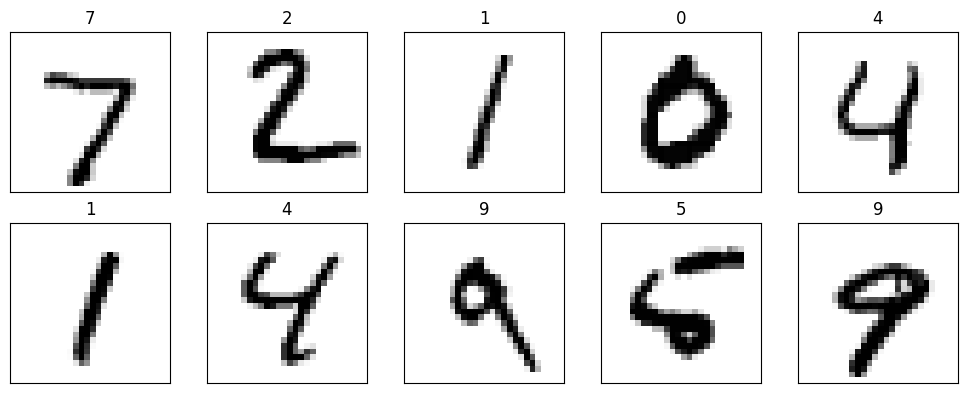

In [15]:
import matplotlib.pyplot as plt 

def plot_images(images, labels):
    cols = 5
    rows = (len(labels) + cols - 1) // cols 

    plt.figure(figsize=(cols * 2, rows * 2))

    for i, (img, lab) in enumerate(zip(images, labels)): 
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='binary')
        plt.title(str(lab))
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

plot_images(images[:10], labels[:10])


## Part 2

### Problem 1

Write functions linear_load(file_name) and linear_save(file_name, network) to load and save a linear classifier network = (A, b) using JSON. Test your functions on mnist_linear.weights.



In [16]:
import json

def linear_load(filename):
    with open(filename, 'r') as f:
        weights = eval(f.read().strip())
        return [np.array(w) for w in weights]
    
def linear_save(filename, network):
    A, b = network
    np.savez(filename, A, b)

### Problem 2 

Write function image_to_vector(image) that converts an image (list-of-lists) with integer pixel values in the range [0, 255] to an image vector (list) with pixel values being floats in the range [0, 1].



In [17]:
def image_to_vector(image):
    return image.reshape(1, image.size) / 255

### Problem 3

Write functions for basic linear algebra add(U, V), sub(U, V), scalar_multiplication(scalar, V) multiply(V, M), transpose(M) where V and U are vectors and M is a matrix. Include assertions to check if the dimensions of the arguments to add and multiply fit.



In [18]:
def add(U, V):
    assert len(U) == len(V), 'Vectors must be of equal length.'
    return [U[i] + V[i] for i in range(len(U))]

def sub(U, V):
    assert len(U) == len(V), 'Vectors must be of equal length.'
    return [U[i] - V[i] for i in range(len(U))]

def scalar_mult(c, V):
    return [c * v for v in V]

def mult(V, M):
    assert len(M) == len(V), 'Rowcount must equal vector length.'
    return [sum(V[i] * M[i][j] for i in range(len(V))) for j in range(len(M[0]))]

def transpose(M):
    return [[M[i][j] for i in range(len(M))] for j in range(len(M[0]))]

### Problem 4 

Write a function mean_square_error(U, V) to compute the mean squared error between two vectors.



In [19]:
def mse(U, V):
    assert len(U) == len(V), 'Vectors must be of equal length'
    return ((U-V)**2).mean()

### Problem 5

Write function a function argmax(V) that returns an index into the list V with maximal value (corresponding to numpy.argmax).



In [20]:
def argmax(V):
    return V.index(max(V))

### Problem 6

Implement a function categorical(label, classes=10) that takes a label from [0, 9] and returns a vector of length classes, with all entries being zero, except entry label that equals one. For an image with this label, the categorical vector is the expected ideal output of a perfect network for the image.



In [21]:
def categorical(label, classes=10):
    a = np.zeros(classes)
    a[label] = 1
    return a

### Problem 7

Write a function predict(network, image) that returns xA + b, given a network (A, b) and a list of images.



In [22]:
def predict(network, images):
    A, b = network
    return images.reshape(len(images), 28*28) / 255 @ A + b 

### Problem 8

Create a function evaluate(network, images, labels) that given a list of image vectors and corresponding labels, returns the tuple (predictions, cost, accuracy), where predictions is a list of the predicted labels for the images, cost is the average of mean square errors over all input-output pairs, and accuracy the fraction of inputs where the predicted labels are correct. Apply this to the loaded network and the 10.000 test images in t10k-images. The accuracy should be around 92%, whereas the cost should be 230 (the cost is very bad since the network was trained to optimze the cost measure softmax).



In [23]:
def evaluate(network, images, labels, cost=mse):
    A, b = network
    fitted_vals = predict(network, images)
    predictions = np.argmax(fitted_vals, axis=1)
    categoricals = np.eye(A.shape[1])[labels]
    loss = cost(fitted_vals, categoricals)
    accuracy = np.mean(predictions == labels)

    return predictions, loss, accuracy

### Problem 9

Extend plot_images to take an optional argument prediction that is a list of predicted labels for the images, and visualizes if the prediction is correct or wrong. Test it on a set of images from t10k-images and their correct labels from t10k-labels.



In [24]:
def plot_images(images, labels, prediction=[]):
    cols = 5
    rows = (len(labels) + cols - 1) // cols 

    plt.figure(figsize=(cols * 2, rows * 2))
    
    if len(prediction) == len(labels):
        for i, (img, lab, pred) in enumerate(zip(images, labels, prediction)): 
            plt.subplot(rows, cols, i+1)
            if lab == pred:
                plt.imshow(img, cmap='binary')
                plt.title(str(lab))
            else:
                plt.imshow(img, cmap='Reds')
                plt.title(f'{pred}, correct {lab}', color='red')

            plt.xticks([])
            plt.yticks([])
    else:
        for i, (img, lab) in enumerate(zip(images, labels)): 
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap='binary')
            plt.title(str(lab))
            plt.xticks([])
            plt.yticks([])


    plt.tight_layout()
    plt.show()

images2 = read_images('t10k-images.idx3-ubyte')
labels = read_labels('t10k-labels.idx1-ubyte')

# plot_images(images2[:10], labels[:10], predictions[:10])


### Problem 10

Column i of matrix A contains the (positive or negative) weight of each input pixel for class i, i.e. the contribution of the pixels towards the image showing the digit i. Use imshow to visualize each column (each column is a vector of length 784 that should be reshaped to an image of size 28 × 28).



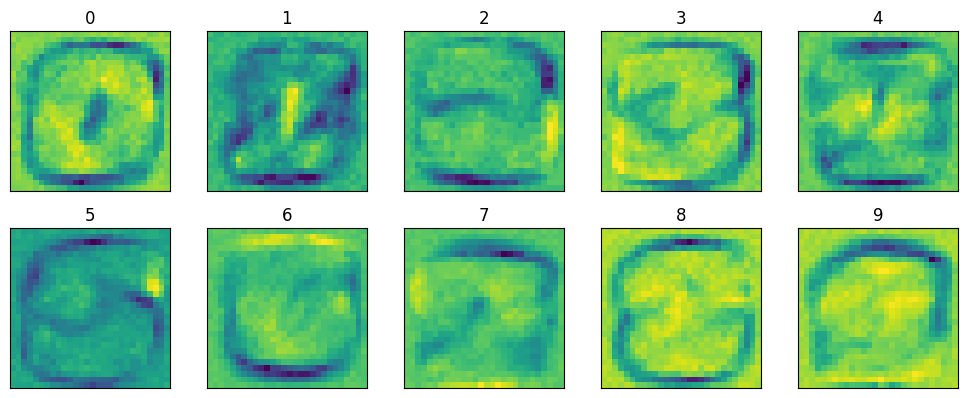

In [25]:
classes = 10 
size = 28
A = linear_load('mnist_linear.weights')[0]


plt.figure(figsize=(classes, classes))
for i in range(classes):
    plt.subplot(5, 5, i+1)
    plt.imshow([A.T[i][j:j+size] for j in range(0,len(A.T[i]), size)])
    plt.title(str(i))
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()


## Part 3

### Problem 1 

Create function create_batches(values, batch_size) that partitions a list of values into batches of size batch_size, except for the last batch, that can be smaller. The list should be permuted before being cut into batches.



In [26]:
def create_batches(values, batch_size):
    return np.array_split(values, np.arange(batch_size, len(values), batch_size))

### Problem 2 

Create a function update(network, images, labels) that updates the network network = (A, b) given a batch of n image vectors and corresponding output labels (performs one step of a stochastical gradient descend in the 784 · 10 + 10 = 7850 dimensional space where all entries of A and b are considered to be variables).

For each input in the batch, we consider the tuple (x, a, y), where x is the image vector, a = xA + b the current network’s output on input x, and y the corresponding categorical vector for the label. The biases b and weights A are updated as follows:

bj -= σ · (1 / n) · ∑(x,a,y) 2 · (aj - yj) / 10

Aij -= σ · (1 / n) · ∑(x,a,y) xi · 2 · (aj - yj) / 10

For this problem an appropriate value for the step size σ of the gradient descend is σ = 0.1.

In the above equations 2 · (aj -yj) / 10 is the derivative of the cost function (mean squared error) wrt. to the output aj, whereas xi · 2 · (aj - yj) / 10 is the derivative of the cost function w.r.t. to Aij — both for a specific image (x, a, y).

In [27]:
# Cross-entropy (see Part 4, Problem 1)
def softmax(a):
    return np.exp(a)/np.sum(np.exp(a), axis=1)[:, np.newaxis]

def ce(a, y):
    return - np.mean(y * np.log(softmax(a)))

def update(network, images, labels, cost=mse, sigma=0.1): 
    A, b = network
    n = len(labels)
    x = images.reshape(n, 28*28).T / 255
    a = predict(network, images)
    y = np.eye(A.shape[1])[labels]
    if cost == mse:
        A -= 2 * sigma/n * x @ (a - y) / 10
        b -= sigma/n * np.sum(2 * (a - y) / 10, axis=0)        
    if cost == ce:
        A -= sigma/n * x @ (softmax(a)-y)
        b -= sigma/n * np.sum(softmax(a)-y, axis=0)
    return A, b

### Problem 3

Create a function learn(images, labels, epochs, batch_size) to train an initially random network on a set of image vectors and labels. First initialize the network to contain random weights: each value of b to be a uniform random value in [0, 1], and each value in A to be a uniform random value in [0, 1 / 784]. Then perform epochs epochs, each epoch consiting of partitioning the input into batches of batch_size images, and calling update with each of the batches. Try running your learning function with epochs=5 and batch_size=100 on the MNIST training set train-images and train-labels.



In [30]:
def learn(images, labels, epochs, batch_size, cost=mse):
    A = np.random.uniform(0, 1/784, (784, 10))
    b = np.random.uniform(0, 1, 10)
    network = A, b
    test_images = read_images('t10k-images.idx3-ubyte')
    test_labels = read_labels('t10k-labels.idx1-ubyte')
    for i in range(epochs):
        indices = np.random.permutation(len(images))
        images = images[indices]
        labels = labels[indices] 
        
        images_batches = create_batches(images, batch_size)
        labels_batches = create_batches(labels, batch_size)
        for j in range(len(labels_batches)):
            network = update(network, images_batches[j], labels_batches[j], cost)
        loss, acc = evaluate(network, test_images, test_labels)[1:]
        print(f'Epoch {i+1} complete. Accuracy: {acc} - loss: {round(loss, 3)}')

    return network 

network = learn(images, labels, epochs=10, batch_size=100)


Epoch 1 complete. Accuracy: 0.8266 - loss: 0.059
Epoch 2 complete. Accuracy: 0.8429 - loss: 0.053
Epoch 3 complete. Accuracy: 0.8473 - loss: 0.05
Epoch 4 complete. Accuracy: 0.8541 - loss: 0.047
Epoch 5 complete. Accuracy: 0.8572 - loss: 0.045
Epoch 6 complete. Accuracy: 0.8646 - loss: 0.044
Epoch 7 complete. Accuracy: 0.8635 - loss: 0.042
Epoch 8 complete. Accuracy: 0.8682 - loss: 0.042
Epoch 9 complete. Accuracy: 0.865 - loss: 0.041
Epoch 10 complete. Accuracy: 0.8716 - loss: 0.04


## Part 4 

### Problem 1 

Instead of using the mean squared error as the cost function try to use the categorical cross entropy (see e.g. this blog): On output a where the expected output is the categorical vector y, the categorical cross entropy is defined as CE(y, softmax(a)), where softmax(a)i = eai / (∑j eaj) and the cross entropy is defined as CE(y, â) = - ∑i (yi · log âi).



In [37]:
def softmax(a):
    return np.exp(a)/np.sum(np.exp(a), axis=1, keepdims=True)

def ce(a, y):
    return - np.mean(y * np.log(softmax(a)))

network = learn(images, labels, epochs=10, batch_size=100, cost=ce)

Epoch 1 complete. Accuracy: 0.8676 - loss: 2.953
Epoch 2 complete. Accuracy: 0.8854 - loss: 4.636
Epoch 3 complete. Accuracy: 0.8953 - loss: 5.915
Epoch 4 complete. Accuracy: 0.9028 - loss: 7.01
Epoch 5 complete. Accuracy: 0.9056 - loss: 7.776
Epoch 6 complete. Accuracy: 0.9112 - loss: 8.693
Epoch 7 complete. Accuracy: 0.9133 - loss: 9.196
Epoch 8 complete. Accuracy: 0.9147 - loss: 9.812
Epoch 9 complete. Accuracy: 0.9158 - loss: 10.359
Epoch 10 complete. Accuracy: 0.9182 - loss: 10.882


(784, 10)

### Problem 2 

Load your own handwritten digit and use it to test the model. 

5


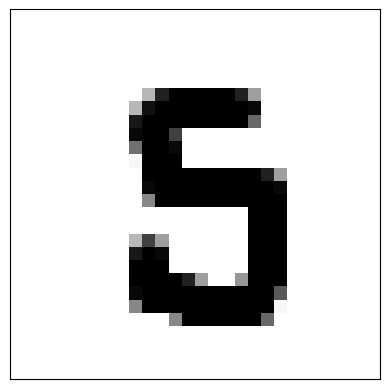

In [ ]:
from PIL import Image 

image = Image.open('hand5.png').convert('L')
image = 255 - np.array(image)

A, b = network

print(np.argmax(image.reshape(1, 784) / 255 @ A + b))

plt.imshow(image, cmap='binary')
plt.xticks([])
plt.yticks([])
plt.show()


### Problem 3

Add a hidden layer to the model. (ReLU)

In [4]:
import numpy as np

def initialize_network(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) / 784
    b1 = np.random.randn(1, hidden_size)
    W2 = np.random.randn(hidden_size, output_size) / 784
    b2 = np.random.randn(1, output_size)
    return W1, b1, W2, b2 

def softmax(a):
    exp_a = np.exp(a - np.max(a, axis=1, keepdims=True)) # Prevent exp(inf)
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def cross_entropy(a, y):
    eps = 1e-15
    a = np.clip(a, eps, 1-eps) # Prevent log(0)
    return -np.sum(y * np.log(a)) / y.shape[0]

def ReLU(x):
    return x * (x > 0)

def forward_pass(network, X):
    W1, b1, W2, b2 = network
    Z1 = X @ W1 + b1
    A1 = ReLU(Z1)
    Z2 = A1 @ W2 + b2 
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2 

def back_prop(network, forward_cache, X, Y):
    Z1, A1, Z2, A2 = forward_cache
    W2 = network[2]
    m = X.shape[0]

    # Gradients 
    dZ2 = A2 - Y
    dW2 = A1.T @ dZ2 / m 
    db2 = np.sum(dZ2) / m

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (Z1 > 0)
    dW1 = X.T @ dZ1 / m 
    db1 = np.sum(dZ1) / m

    return dW2, db2, dW1, db1

def update(network, gradients, sigma=0.1):
    W1, b1, W2, b2 = network
    dW2, db2, dW1, db1 = gradients

    W1 = W1 - sigma * dW1
    b1 = b1 - sigma * db1 
    W2 = W2 - sigma * dW2
    b2 = b2 - sigma * db2
    return W1, b1, W2, b2

def learn(network, X, Y, epochs, batch_size, sigma=0.1):
    for epoch in range(epochs):
        indices = np.random.permutation(len(X))
        X_shuffle = X[indices]
        Y_shuffle = Y[indices]

        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffle[i:i+batch_size]
            Y_batch = Y_shuffle[i:i+batch_size]
            forward_cache = forward_pass(network, X_batch)
            gradients = back_prop(network, forward_cache, X_batch, Y_batch)
            network = update(network, gradients)

        A2_full = forward_pass(network, X)[2]
        loss = cross_entropy(A2_full, Y)
        acc = np.mean(np.argmax(A2_full, axis=1) == np.argmax(Y, axis=1))
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Accuracy: {acc:.4f} - loss: {loss:.4f}')
        print()
    
    return network

In [5]:
def read_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    magic, num_items, num_rows, num_cols = np.frombuffer(data[:16], dtype='>i4')
    if magic != 2051:
        raise ValueError('Wrong number, moron')
    return np.frombuffer(data[16:], dtype='uint8').reshape(num_items, num_rows, num_cols)

def read_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    magic, num_items = np.frombuffer(data[:8], dtype='>i4')
    if magic != 2049:
        raise ValueError('Wrong number, moron')
    return np.frombuffer(data[8:], dtype='uint8')

# Flatten images 
X = read_images('train-images.idx3-ubyte').reshape(60000, 784) / 255

# One-hot encode labels
Y = np.eye(10)[read_labels('train-labels.idx1-ubyte')]

network = initialize_network(input_size=784, hidden_size=16, output_size=10)
network = learn(network, X, Y, epochs=10, batch_size=100, sigma=0.01)

Epoch 1/10
Accuracy: 0.8915 - loss: 0.2274

Epoch 2/10
Accuracy: 0.9126 - loss: 0.1619

Epoch 3/10
Accuracy: 0.9200 - loss: 0.1422

Epoch 4/10
Accuracy: 0.9254 - loss: 0.1274

Epoch 5/10
Accuracy: 0.9279 - loss: 0.1178

Epoch 6/10
Accuracy: 0.9292 - loss: 0.1111

Epoch 7/10
Accuracy: 0.9309 - loss: 0.1058

Epoch 8/10
Accuracy: 0.9341 - loss: 0.0974

Epoch 9/10
Accuracy: 0.9355 - loss: 0.0932

Epoch 10/10
Accuracy: 0.9379 - loss: 0.0874



Evaluating model on test data

In [7]:
X_test = read_images('t10k-images.idx3-ubyte').reshape(10000, 784) / 255
Y_test = read_labels('t10k-labels.idx1-ubyte')

A2 = forward_pass(network, X_test)[2]
predict = np.argmax(A2, axis=1)
print(f'Accuracy: {np.mean(predict == Y_test):.4f} - loss: {cross_entropy(A2, np.eye(10)[Y_test]):.4f}')


Accuracy: 0.9379 - loss: 0.0810


Testing on hand-drawn digit

5


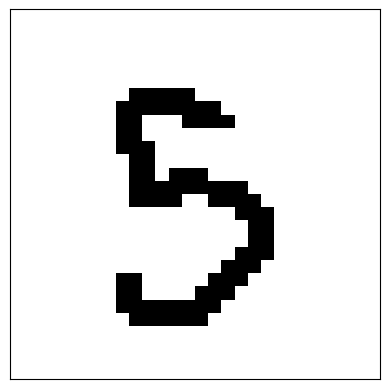

In [30]:
import matplotlib.pyplot as plt
from PIL import Image 

image = Image.open('hand5.png').convert('L')
image = 255 - np.array(image)
x = image.reshape(1, 784) / 255
A2_x = forward_pass(network, x)[2]
print(np.argmax(A2_x))

plt.imshow(image, cmap='binary')
plt.xticks([])
plt.yticks([])
plt.show()



### Problem 4

Optional: Compare your pure Python solution with the solution using Keras, e.g. on running time, accuracy achieved, epochs.


In [28]:
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = keras.datasets.mnist.load_data(path='mnist.npz')

# Flatten and normalize images
images_train = images_train.reshape(60000, 28*28).astype('float32') / 255
images_test = images_test.reshape(10000, 28*28).astype('float32') / 255

# One-hot encode labels 
labels_train, labels_test = map(keras.utils.to_categorical, (labels_train, labels_test))

# Initialize neural network 
network = keras.models.Sequential()
network.add(keras.Input(shape=(28 * 28,)))

# 2 hidden layers
network.add(keras.layers.Dense(128, activation='relu'))
network.add(keras.layers.Dense(128, activation='relu'))
network.add(keras.layers.Dense(10, activation='softmax'))

network.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',  # for small loss
    metrics=['accuracy']
)

network.fit(images_train, labels_train, epochs=10, batch_size=100)


Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8672 - loss: 0.4754
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.1307
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9747 - loss: 0.0836
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9801 - loss: 0.0639
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9843 - loss: 0.0510
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9880 - loss: 0.0385
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9903 - loss: 0.0313
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9915 - loss: 0.0258
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9937 - loss: 0.0207
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9951 - loss: 0.0167


In [29]:
network.save('mnist_tensorflow.keras')
model = keras.models.load_model('mnist_tensorflow.keras')

model.evaluate(images_test, labels_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9745 - loss: 0.1154


[0.09817425906658173, 0.9768999814987183]